In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

In [2]:
image = plt.imread('input_images/1.jpg')

In [3]:
#The shape of the image is:
image.shape

(478, 485, 3)

##### The height of the image is 478 pixels, its width is 485 pixels, and it has 3 color channels (RGB).

##### Since SVD can only be applied to 2D data, we can either execute it on each color channel separately, or we can reshape the image from a 3D matrix to a 2D matrix by flattening each color channel and stacking them horizontally (or vertically).

##### For example, the following code snippet reshapes the image into a 2D matrix by stacking the color channels horizontally:

In [21]:
height, width, channels = image.shape
flat_image = image.reshape(-1, width * channels)

In [22]:
flat_image

array([[  4,  24,  35, ...,  31,  32,  36],
       [  1,  21,  32, ...,  31,  32,  36],
       [  0,  20,  31, ...,  31,  32,  36],
       ...,
       [238, 249, 245, ...,  31,  33,  32],
       [239, 248, 243, ...,  31,  33,  32],
       [239, 248, 243, ...,  31,  33,  32]], dtype=uint8)

In [23]:
# The shape of the flattened image is
flat_image.shape

(478, 1455)

In [24]:
# The rank of the image’s matrix is:
np.linalg.matrix_rank(flat_image)

478

##### The matrix is of full rank (since min(478, 1455) = 478).

##### Let’s plot the first 100 singular values of the matrix:

In [26]:
U, S, Vt = np.linalg.svd(flat_image)

Text(0, 0.5, 'Magnitude of singular value')

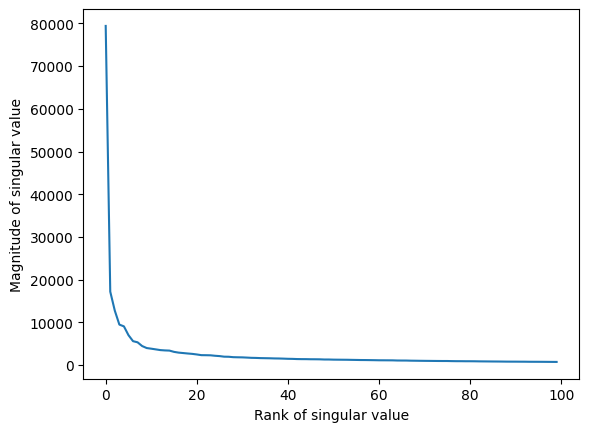

In [27]:
k = 100
plt.plot(np.arange(k), S[:k])
plt.xlabel('Rank of singular value')
plt.ylabel('Magnitude of singular value')

##### We can clearly see a rapid decay in the singular values. This decay means that we can effectively truncate the image without a significant loss of accuracy.

##### For example, let’s truncate the image to have a rank of 100 using Truncated SVD:

In [13]:
svd = TruncatedSVD(n_components=100)
truncated_image = svd.fit_transform(flat_image)

In [28]:
# The shape of the truncated image is:
truncated_image.shape

(478, 100)

##### The size of the truncated image is only 100/1455 = 6.87% of the original image!

##### To see how much information was lost in the compression we can measure the image’s reconstruction error. We will measure the reconstruction error as the mean of squared errors (MSE) between the the pixel values of the original image and the reconstructed image.

##### In Scikit-Learn, the reconstructed image can be obtained by calling the method inverse_transform of the TruncatedSVD transformer:

In [29]:
reconstructed_image = svd.inverse_transform(truncated_image)

In [30]:
# Therefore, the reconstruction error is
reconstruction_error = np.mean(np.square(reconstructed_image - flat_image))
reconstruction_error

40.12889196504625

##### Thus, the root mean squared error (RMSE) between the pixel intensities in the original image and the reconstructed image is only about 5.41 (which is small relative to the range of the pixels [0, 255]).

##### To display the reconstructed image, we first need to reshape it into the original 3D shape and then clip the pixel values to integers in the range [0, 255]: 

In [32]:
reconstructed_image = reconstructed_image.reshape(height, width, channels)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype('uint8')

##### We can now display the image using the plt.imshow function:

(-0.5, 484.5, 477.5, -0.5)

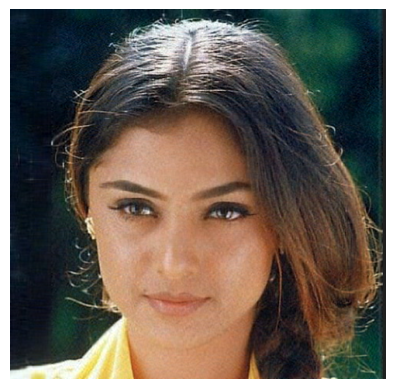

In [33]:
plt.imshow(reconstructed_image)
plt.axis('off')

##### We can see that the reconstruction at rank 100 loses only a small amount of detail

##### Let’s place all the above steps into a function that compresses a given 3D image to a specified number of dimensions and then reconstructs it:

In [19]:
def compress_image(image, n_components=100):   
    # Reshape the 3D image into a 2D array by stacking the color channels horizontally
    height, width, channels = image.shape
    flat_image = image.reshape(-1, width * channels)

    # Truncate the image using SVD
    svd = TruncatedSVD(n_components=n_components)  
    truncated_image = svd.fit_transform(flat_image)

    # Recover the image from the reduced representation
    reconstructed_image = svd.inverse_transform(truncated_image)

    # Reshape the image to the original 3D shape
    reconstructed_image = reconstructed_image.reshape(height, width, channels)

    # Clip the output to integers in the range [0, 255]
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype('uint8')
    return reconstructed_image

##### We can now call this function with different number of components and examine the reconstructions:

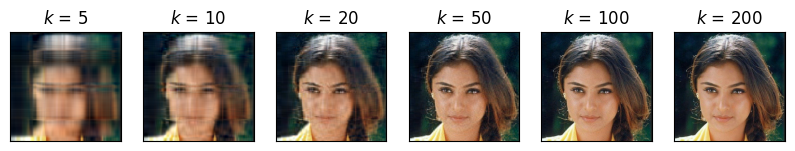

In [36]:
fig, axes = plt.subplots(1, 6, figsize=(10, 50))
plt.setp(axes, xticks=[], yticks=[])  # Remove axes from the subplots

for i, k in enumerate([5, 10, 20, 50, 100,200]):
    output_image = compress_image(image, k)    
    axes[i].imshow(output_image)
    axes[i].set_title(f'$k$ = {k}')

##### As we can see, using a rank that is too low, such as k = 10, can lead to a substantial loss of information, while an SVD of rank 200 is almost indistinguishable from the full-rank image.

##### In addition to compressing images, SVD can also be used to remove noise from images. This is because discarding the lower-order components of the image tends to remove the granular, noisy elements, while preserving the more significant parts of the image.